# Sales order Analysis

### Loading csv file from lakehouse into spark dataframe

In [1]:
# let's read csv files

df = spark.read.format('csv').option('header','true').load('Files/orders/2019.csv')

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 3, Finished, Available, Finished)

In [2]:
display(df)

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 4, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, ec26c6ce-9019-4e58-b24a-2e253e483a0f)

In [3]:
# since our first row value is treated a column header so let's fix this using SchemaStruct

from pyspark.sql.types import *

OrderSchema = StructType([
     StructField("SalesOrderNumber", StringType()),
     StructField("SalesOrderLineNumber", IntegerType()),
     StructField("OrderDate", DateType()),
     StructField("CustomerName", StringType()),
     StructField("Email", StringType()),
     StructField("Item", StringType()),
     StructField("Quantity", IntegerType()),
     StructField("UnitPrice", FloatType()),
     StructField("Tax", FloatType())
])

df = spark.read.format('csv').schema(OrderSchema).load('Files/orders/*.csv')
# I used * to include all files as one dataframe as they have equal number of column

display(df)

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 5, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 3931b083-f3b0-4a08-a8d2-f4ecfa216b92)

## Exploring data in a DataFrame

In [4]:
# let's extract customers 

customers = df.select('CustomerName','Email')

# customers = df['CustomerName','Email']

print(customers.distinct().count())
display(customers)

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 6, Finished, Available, Finished)

12427


SynapseWidget(Synapse.DataFrame, ae09791f-3413-4989-b3d7-814378eb99a5)

In [5]:
df.columns

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 7, Finished, Available, Finished)

['SalesOrderNumber',
 'SalesOrderLineNumber',
 'OrderDate',
 'CustomerName',
 'Email',
 'Item',
 'Quantity',
 'UnitPrice',
 'Tax']

In [6]:
# let's use groupBy for sum of quanity with items

productSales = df.select('Item','Quantity').groupBy('Item').sum()
display(productSales)

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 63b214e6-e5c1-47a0-a94c-ebfebcc7e46a)

In [7]:
# let's extract year by sales
from pyspark.sql.functions import *

SalesYear = df.select(year(col('OrderDate')).alias('Year')).groupBy('Year').count().orderBy('Year')

display(SalesYear)

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 9, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 4302ac80-01e9-4d90-bc46-5111458fdfa6)

## Transform data using DataFrame

In [8]:
# create year and month column using orderdate

transformed_df = df.withColumn('Year', year(col('OrderDate'))).withColumn('Month',month(col('OrderDate')))

transformed_df.columns

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 10, Finished, Available, Finished)

['SalesOrderNumber',
 'SalesOrderLineNumber',
 'OrderDate',
 'CustomerName',
 'Email',
 'Item',
 'Quantity',
 'UnitPrice',
 'Tax',
 'Year',
 'Month']

In [13]:
display(transformed_df.select('CustomerName'))

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 15, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, d0294128-7165-4eb0-add0-c8e93fd7fac3)

In [15]:
# create new first name last name fields from CustomerName

transformed_df = transformed_df.withColumn('FirstName',split(col('CustomerName')," ").getItem(0)).withColumn('LastName',split(col('CustomerName')," ").getItem(0))

display(transformed_df)

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 17, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 09355723-5ea3-4a1f-8325-56f20f6ba60e)

In [16]:

 # Filter and reorder columns
 transformed_df = transformed_df["SalesOrderNumber", "SalesOrderLineNumber", "OrderDate", "Year", "Month", "FirstName", "LastName", "Email", "Item", "Quantity", "UnitPrice", "Tax"]

 # Display the first five orders
 display(transformed_df.limit(5))

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 18, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 18fff7a2-3ea9-4333-9ce7-aac380f92bee)

## Saving the data in parquet format

In [17]:
transformed_df.write.parquet('Files/transformed_data/orders')

print('success')

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 19, Finished, Available, Finished)

success


In [18]:
# let's load and check

orders_df = spark.read.format('parquet').load('Files/transformed_data/orders')

display(orders_df.limit(5))

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 20, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 9c0bf006-e6eb-4c50-9ee8-9d79d241a8c7)

## Now let's try to save data partitionBy

In [19]:
transformed_df.write.partitionBy('Year','Month').mode('overwrite').parquet('Files/partitioned_data')

print('success')

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 21, Finished, Available, Finished)

success


In [21]:
pdf = spark.read.format('parquet').load('Files/partitioned_data/Year=2021/Month=*')

display(pdf.limit(5))

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 23, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, a26b4b66-5762-413b-9dee-5c3d66cec638)

## working with tables and SQL

In [22]:
display(df.limit(5))

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 24, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 35423a6c-7178-4984-9108-c0e756ab5397)

In [23]:
df.write.format('delta').saveAsTable('salesorders')

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 25, Finished, Available, Finished)

In [25]:
spark.sql('DESCRIBE extended salesorders').show(truncate=False)

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 27, Finished, Available, Finished)

+----------------------------+-------------------------------------------------------------------------------------------------------------------------------------+-------+
|col_name                    |data_type                                                                                                                            |comment|
+----------------------------+-------------------------------------------------------------------------------------------------------------------------------------+-------+
|SalesOrderNumber            |string                                                                                                                               |NULL   |
|SalesOrderLineNumber        |int                                                                                                                                  |NULL   |
|OrderDate                   |date                                                                                                     

In [26]:
sql_df = spark.sql('SELECT * FROM salesorders')

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 28, Finished, Available, Finished)

In [27]:
display(sql_df)

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 29, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 8aacdd62-c2b7-4287-b245-928ebc606b90)

In [34]:
# running SQl

from pyspark.sql.functions import *

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 36, Finished, Available, Finished)

In [38]:
%%sql


 SELECT YEAR(OrderDate) AS OrderYear,
        SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue
 FROM salesorders
 GROUP BY YEAR(OrderDate)
 ORDER BY OrderYear;

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 40, Finished, Available, Finished)

<Spark SQL result set with 3 rows and 2 fields>

## Vizualization

In [41]:
%%sql
SELECT * FROM salesorders

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 43, Finished, Available, Finished)

<Spark SQL result set with 1000 rows and 9 fields>

In [46]:
sqlQuery = "SELECT CAST(YEAR(OrderDate) AS CHAR(4)) AS OrderYear, \
                 SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue \
             FROM salesorders \
             GROUP BY CAST(YEAR(OrderDate) AS CHAR(4)) \
             ORDER BY OrderYear"
df_spark = spark.sql(sqlQuery)
df_spark.show()

StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 48, Finished, Available, Finished)

+---------+--------------------+
|OrderYear|        GrossRevenue|
+---------+--------------------+
|     2019|   4172169.969970703|
|     2020|   6882259.268127441|
|     2021|1.1547835291696548E7|
+---------+--------------------+



StatementMeta(, 4517125c-728e-46f8-97ec-37d7094afbb8, 49, Finished, Available, Finished)

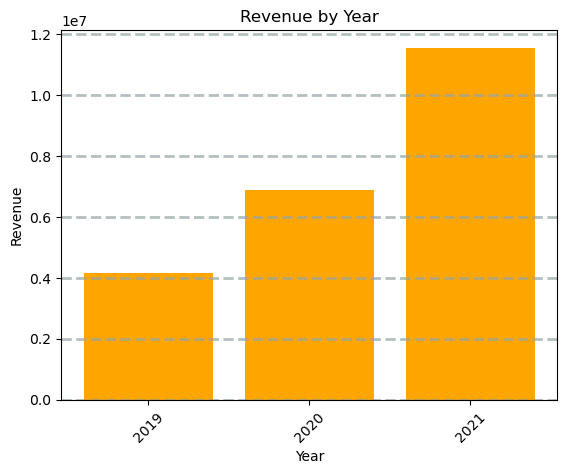

In [47]:
from matplotlib import pyplot as plt

df_sales = df_spark.toPandas()

# Create a bar plot of revenue by year
plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')

# Customize the chart
plt.title('Revenue by Year')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation=45)

# Show the figure
plt.show()